In [23]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
from typing import cast
import h5py
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import argparse

In [24]:
# Constants
batch_size = 128
num_workers = 10
n_geno = 100000
n_alleles = 2
n_loci = n_geno * n_alleles


n_loci = 100000
n_alleles = 2
window_step = 10
window_stride = 5
glatent = 2000
input_length = n_loci * n_alleles
n_out_channels = 3

n_epochs = 1
batch_size = 128
num_workers = 9
n_loci_viz = 1000
#base_file_name = '../gpatlas_input/test_sim_WF_10kbt_10000n_5000000bp_'
test_data = '../gpatlas_input/test_sim_WF_10kbt_10000n_5000000bp_test.hdf5'
saved_model_name = 'localgg_autenc_10kbt_V3_state_dict.pt'

device = torch.device("cpu")

In [25]:

# Dataset classes
class BaseDataset(Dataset):
    def __init__(self, hdf5_path: Path) -> None:
        self.h5 = h5py.File(hdf5_path, "r")
        self._strain_group = cast(h5py.Group, self.h5["strains"])
        self.strains: list[str] = list(self._strain_group.keys())

    def __len__(self) -> int:
        return len(self._strain_group)

class GenoDataset(BaseDataset):
    def __getitem__(self, idx: int) -> torch.Tensor:
        strain = self.strains[idx]
        strain_data = cast(Dataset, self._strain_group[strain])
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()
        return gens


In [26]:

class LDGroupedAutoencoder(nn.Module):
    def __init__(self, input_length=input_length, loci_count=n_loci, window_size=window_step, latent_dim=glatent):
        """
        LD-aware autoencoder for genetic data using grouped convolution.
        Each window of loci is processed independently.

        Args:
            input_length: Total length of input tensor (one-hot encoded, so 2 values per locus)
            loci_count: Actual number of genetic loci (half of input_length)
            window_size: Number of loci to group together in local connections
            latent_dim: Dimension of the latent space
        """
        super().__init__()

        self.input_length = input_length  # 200,000 values for 100,000 loci
        self.loci_count = loci_count      # 100,000 loci
        self.window_size = window_size    # 10 loci per group
        self.latent_dim = latent_dim      # Latent space dimension
        self.n_out_channels = n_out_channels  # number of output channels per LD window

        # Calculate the number of groups
        self.n_groups = loci_count // window_size  # 10,000 groups

        # Encoder layers
        self.encoder_conv = nn.Conv1d(
            in_channels=self.n_groups,           # One channel per window
            out_channels=self.n_groups*n_out_channels,          # One output per window
            kernel_size=window_size * 2,         # Cover entire window (2 alleles per locus)
            stride=window_stride,              # Non-overlapping
            groups=self.n_groups,                # Each window processed independently
            bias=True
        )

        self.encoder_act = nn.LeakyReLU(0.2)

        # Fully connected layer to latent space
        self.encoder_fc = nn.Linear(self.n_groups*n_out_channels, latent_dim)
        self.encoder_fc_act = nn.LeakyReLU(0.1)

        # Decoder - mirror of encoder
        self.decoder_fc = nn.Linear(latent_dim, self.n_groups*n_out_channels)
        self.decoder_fc_act = nn.LeakyReLU(0.1)

        # Expand each window back to original size
        self.decoder_conv = nn.ConvTranspose1d(
            in_channels=self.n_out_channels * self.n_groups,
            out_channels=self.n_groups,
            kernel_size=window_size * 2,
            stride=window_stride,
            groups=self.n_groups,
            bias=True
        )

        self.final_act = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass through the autoencoder

        Args:
            x: Input tensor of shape [batch_size, input_length]

        Returns:
            Reconstructed tensor of shape [batch_size, input_length]
        """
        # Input shape: [batch_size, input_length]
        #print(f"Input shape: {x.shape}")
        #print(f"n_groups: {self.n_groups}, window_size: {self.window_size}")


        batch_size = x.size(0)
        #print(f"Attempting to reshape to: {batch_size}, {self.n_groups}, {self.window_size * 2}")

        # Reshape to group by windows
        # [batch_size, input_length] -> [batch_size, n_groups, window_size*2]
        x = x.reshape(batch_size, self.n_groups, self.window_size * 2)

        # Apply grouped convolution - each window processed independently
        x = self.encoder_conv(x)
        x = self.encoder_act(x)

        # Flatten to [batch_size, n_groups]
        x = x.reshape(batch_size, self.n_groups * n_out_channels)

        # Map to latent space
        latent = self.encoder_fc(x)
        latent = self.encoder_fc_act(latent)

        # Decode from latent space
        x = self.decoder_fc(latent)
        x = self.decoder_fc_act(x)

        # Reshape for transposed convolution
        # [batch_size, n_groups*n_out_channels] -> [batch_size, n_groups, n_out_channels]
        x = x.reshape(batch_size, self.n_groups * self.n_out_channels, 1)

        # Expand each window back to original size
        x = self.decoder_conv(x)

        # Reshape to original format
        # [batch_size, n_groups, window_size*2] -> [batch_size, input_length]
        x = x.reshape(batch_size, self.input_length)

        # Apply sigmoid
        x = self.final_act(x)

        return x

    def encode(self, x):
        """
        Encode data to latent space

        Args:
            x: Input tensor of shape [batch_size, input_length]

        Returns:
            Latent representation of shape [batch_size, latent_dim]
        """
        batch_size = x.size(0)

        # Reshape to group by windows
        x = x.reshape(batch_size, self.n_groups, self.window_size * 2)

        # Apply convolution
        x = self.encoder_conv(x)
        x = self.encoder_act(x)

        # Flatten and map to latent space
        x = x.reshape(batch_size, self.n_groups * self.n_out_channels)
        x = self.encoder_fc(x)
        return self.encoder_fc_act(x)

    def decode(self, z):
        """
        Decode from latent space

        Args:
            z: Latent representation of shape [batch_size, latent_dim]

        Returns:
            Reconstructed tensor of shape [batch_size, input_length]
        """
        batch_size = z.size(0)

        # Map from latent space to window representations
        x = self.decoder_fc(z)
        x =  self.decoder_fc_act(x)

        # Reshape for transposed convolution
        x = x.reshape(batch_size, self.n_groups * self.n_out_channels, 1)

        # Expand each window back to original size
        x = self.decoder_conv(x)

        # Reshape to original format
        x = x.reshape(batch_size, self.input_length)

        # Apply sigmoid
        x = self.final_act(x)

        return x


In [27]:
def load_model_state(model, filepath):
    """
    Load a state dictionary into an existing model

    Args:
        model: An instance of the model with matching architecture
        filepath: Path to the saved state dictionary

    Returns:
        Model with loaded state
    """
    model.load_state_dict(torch.load(filepath))
    return model

In [28]:
model_to_load = LDGroupedAutoencoder(
    input_length=200000,  # same as when saving
    loci_count=100000,    # same as when saving
    window_size=window_step,       # same as when saving
    latent_dim=glatent         # same as when saving
)

model_to_load = load_model_state(model_to_load, saved_model_name)
model_to_load.eval()

/tmp/ipykernel_42417/3418566390.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


LDGroupedAutoencoder(
  (encoder_conv): Conv1d(10000, 30000, kernel_size=(20,), stride=(5,), groups=10000)
  (encoder_act): LeakyReLU(negative_slope=0.2)
  (encoder_fc): Linear(in_features=30000, out_features=2000, bias=True)
  (encoder_fc_act): LeakyReLU(negative_slope=0.1)
  (decoder_fc): Linear(in_features=2000, out_features=30000, bias=True)
  (decoder_fc_act): LeakyReLU(negative_slope=0.1)
  (decoder_conv): ConvTranspose1d(30000, 10000, kernel_size=(20,), stride=(5,), groups=10000)
  (final_act): Sigmoid()
)

In [29]:

def evaluate_autoencoder(model_to_load, test_loader, device, threshold=0.5):
    """
    Evaluate the autoencoder performance at the allele level

    Returns:
    - correct_allele: count of correctly reconstructed alleles
    - wrong_allele: count of incorrectly reconstructed alleles
    - invalid_state: count of reconstructed invalid states
    - minor_allele_freq: minor allele frequency for each locus
    """
    # Initialize counters per locus position
    n_positions = n_loci_viz
    correct_allele = np.zeros(n_positions)
    correct_allele_0 = np.zeros(n_positions)
    correct_allele_1 = np.zeros(n_positions)
    wrong_allele = np.zeros(n_positions)
    invalid_state = np.zeros(n_positions)

    # Initialize counters for allele frequencies
    allele1_count = np.zeros(n_positions)  # Count of (1,0) genotypes

    total_samples = 0

    # Process batches
    with torch.no_grad():
        for gens in test_loader:
            batch_size = gens.shape[0]
            total_samples += batch_size

            gens = gens.to(device)
            reconstructed = model_to_load(gens)

            # Convert to binary representation (threshold outputs)
            reconstructed_binary = (reconstructed > threshold).float()

            # Analyze per locus
            for pos in range(n_positions):
                # Get allele pairs for this locus
                allele1_idx = pos * n_alleles
                allele2_idx = pos * n_alleles + 1

                for sample_idx in range(batch_size):
                    true_allele1 = gens[sample_idx, allele1_idx].item()
                    true_allele2 = gens[sample_idx, allele2_idx].item()

                    # Count allele1 (1,0) genotypes for MAF calculation
                    if true_allele1 == 1 and true_allele2 == 0:
                        allele1_count[pos] += 1

                    recon_allele1 = reconstructed_binary[sample_idx, allele1_idx].item()
                    recon_allele2 = reconstructed_binary[sample_idx, allele2_idx].item()

                    # Case 1: Correct allele reconstruction
                    if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2):
                        correct_allele[pos] += 1
                        #track number of correctly reconstructed 0 alleles
                        if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2 and true_allele1 == 1):
                            correct_allele_0[pos] += 1
                        #track number of correctly reconstructed 0 alleles
                        if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2 and true_allele2 == 1):
                            correct_allele_1[pos] += 1
                    # Case 3: Invalid allelic state
                    elif (recon_allele1 == 1 and recon_allele2 == 1) or (recon_allele1 == 0 and recon_allele2 == 0):
                        invalid_state[pos] += 1
                    # Case 2: Wrong allele
                    else:
                        wrong_allele[pos] += 1

    # Calculate MAF
    daf = (1-allele1_count/ total_samples)

    # Convert to percentages
    correct_allele = (correct_allele / total_samples) * 100
    wrong_allele = (wrong_allele / total_samples) * 100
    invalid_state = (invalid_state / total_samples) * 100

    return correct_allele, correct_allele_0, correct_allele_1, wrong_allele, invalid_state, daf, total_samples


In [30]:
#test_data = '../gpatlas_input/test_sim_WF_1kbt_10000n_5000000bp_test.hdf5'
threshold = 0.5
device = torch.device("cpu")

test_data = GenoDataset(test_data)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)


/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 9 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [31]:
correct_allele, correct_allele_0, correct_allele_1, wrong_allele, invalid_state, daf, total_samples = evaluate_autoencoder(
    model_to_load, test_loader, device, threshold
)

In [32]:
dataset = pd.DataFrame({'correct_allele': correct_allele, 'correct_allele_0': correct_allele_0,
                        'correct_allele_1': correct_allele_1,'wrong_allele': wrong_allele,
                        'invalid_state': invalid_state,'daf': daf, 'total_samples' : total_samples})

dataset['maf'] = np.minimum(dataset['daf'], 1 - dataset['daf'])
dataset

,correct_allele,correct_allele_0,correct_allele_1,wrong_allele,invalid_state,daf,total_samples,maf
0,99.933333,1499.0,0.0,0.066667,0.000000,0.000667,1500,0.000667
1,95.133333,1426.0,1.0,4.866667,0.000000,0.048667,1500,0.048667
2,71.200000,905.0,163.0,27.266667,1.533333,0.274000,1500,0.274000
3,73.333333,125.0,975.0,25.800000,0.866667,0.700667,1500,0.299333
4,95.400000,1416.0,15.0,4.600000,0.000000,0.051333,1500,0.051333
...,...,...,...,...,...,...,...,...
995,68.600000,261.0,768.0,30.733333,0.666667,0.550000,1500,0.450000
996,100.000000,1500.0,0.0,0.000000,0.000000,0.000000,1500,0.000000
997,77.933333,364.0,805.0,21.600000,0.466667,0.674667,1500,0.325333
998,78.400000,1055.0,121.0,20.600000,1.000000,0.203333,1500,0.203333


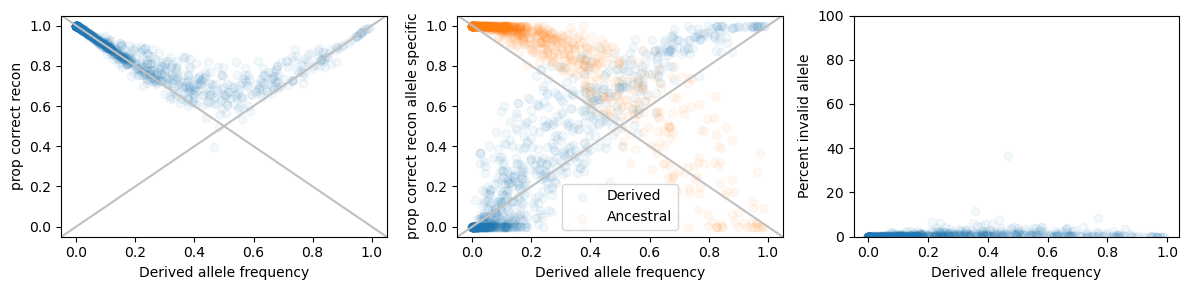

In [33]:
# Create a figure with 2 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 2 columns

# first plot
axes[0].scatter(dataset['daf'], dataset['correct_allele']/100, alpha=0.05)
axes[0].set_xlabel("Derived allele frequency")
axes[0].set_ylabel("prop correct recon")
axes[0].axline((1, 0), slope=-1, color = 'silver')
axes[0].axline((1, 1), slope=1, color = 'silver')


# second plot
axes[1].scatter(dataset['daf'], (dataset['correct_allele_1'])/(1500*dataset['daf']), label='Derived', alpha=0.05)
axes[1].scatter(dataset['daf'], (dataset['correct_allele_0'])/(1500*(1-dataset['daf'])), label='Ancestral', alpha=0.05)
axes[1].set_xlabel("Derived allele frequency")
axes[1].set_ylabel("prop correct recon allele specific")
axes[1].axline((1, 0), slope=-1, color = 'silver')
axes[1].axline((1, 1), slope=1, color = 'silver')
axes[1].legend()

# third plot
axes[2].scatter(dataset['daf'], dataset['invalid_state'], alpha=0.05)
axes[2].set_xlabel("Derived allele frequency")
axes[2].set_ylabel("Percent invalid allele")
axes[2].set_ylim(0, 100)

# Adjust layout and spacing
plt.tight_layout()
plt.show()